In [3]:
import sys
sys.path.append('..')

from functools import reduce, partial
import inspect

from pyquaternion import Quaternion 
from sklearn.metrics import mean_squared_error

from pylab import *
import pandas as pd

np.random.seed=1
%matplotlib inline

import pixiedust

import warnings
warnings.filterwarnings("ignore")

from Utilities import *

Pixiedust database opened successfully


In [4]:
path1 = '../datasets/10hz.csv'
dataset = pd.read_csv(path1)[500:].reset_index()
length, width = dataset.shape

## data is collected at 10 Hz

In [7]:
X, y = getInputOutputVelocityModel(dataset, limit=length, frequency=10.0)

In [8]:
X.head()

,dXB,dYB,dZB,dPsi,dTheta,dPhi,Psi,Theta,moveForward,yawCCW,yawCW,hover
0,-2.552553,-1.579735,-0.270956,-0.005165,-0.032586,0.687370,0.000068,-0.000073,0.0,0.0,1.0,0.0
1,-2.405960,-1.785295,-0.202590,-0.000926,-0.002515,0.844476,-0.000025,-0.000324,0.0,0.0,1.0,0.0
2,-2.148907,-1.951770,-0.154831,-0.000267,0.000088,0.992834,-0.000051,-0.000316,0.0,0.0,1.0,0.0
3,-1.982743,-2.233002,-0.127549,-0.000277,0.000114,1.076587,-0.000079,-0.000304,0.0,0.0,1.0,0.0
4,-1.715801,-2.438663,-0.101797,-0.000312,0.000317,1.132657,-0.000110,-0.000272,0.0,0.0,1.0,0.0


In [9]:
y.head()

,dXB,dYB,dZB,dPsi,dTheta,dPhi
0,-2.405960,-1.785295,-0.202590,-0.000926,-0.002515,0.844476
1,-2.148907,-1.951770,-0.154831,-0.000267,0.000088,0.992834
2,-1.982743,-2.233002,-0.127549,-0.000277,0.000114,1.076587
3,-1.715801,-2.438663,-0.101797,-0.000312,0.000317,1.132657
4,-1.417848,-2.618378,-0.081100,-0.000310,0.000458,1.170188


In [10]:
limit = 8000
integration_error = np.zeros((limit, 6))

## Sanity Check (Velocity)

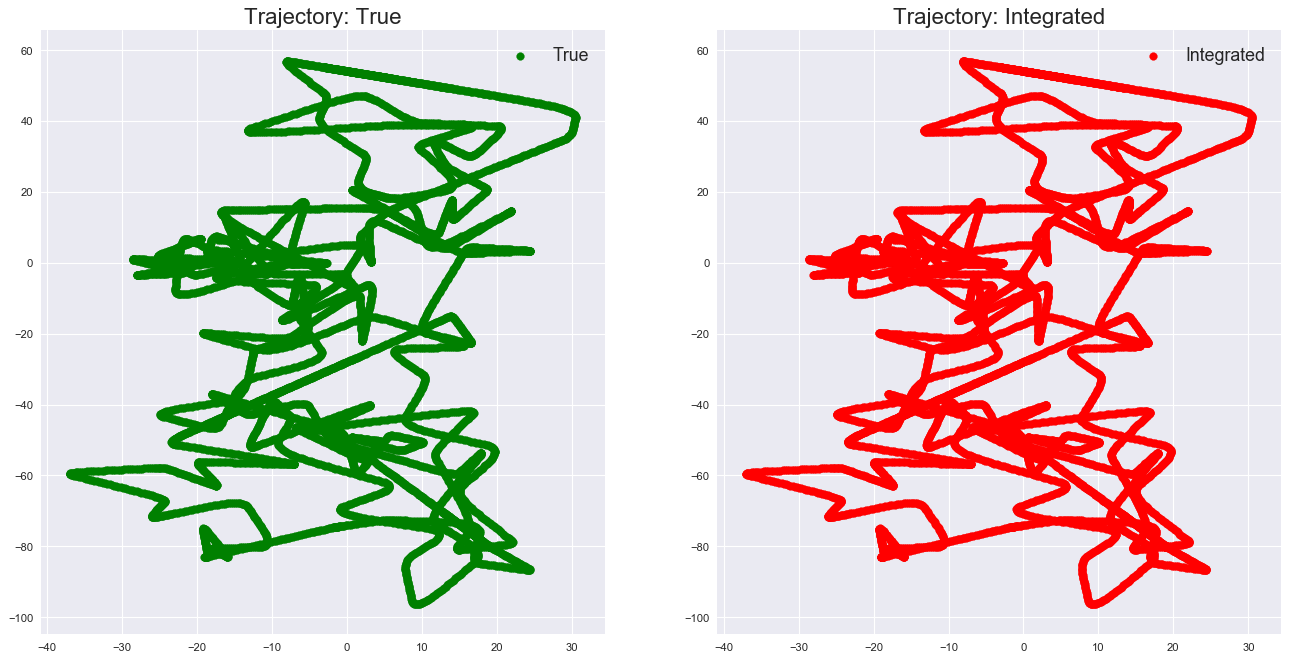

In [11]:
gen1 = integrateTrajectoryVelocityBody(initialPosition=dataset.loc[1, ['x', 'y', 'z']].values,
                                       initialOrientation=dataset.loc[1, ['psi', 'theta', 'phi']].values,
                                       linearVelocitiesBody=y[['dXB', 'dYB', 'dZB']].values,
                                       angularVelocities=y[['dPsi', 'dTheta', 'dPhi']].values,
                                       frequency=10.0 * np.ones((limit, )))

figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')

for i in range(2, limit):
    p, o = next(gen1)
    
    subplot(1, 2, 1)
    legend(['True'], fontsize=16)
    title('Trajectory: True', fontdict={'fontsize':20})
    
    pTrue = dataset.loc[i, ['x', 'y', 'z']]
    oTrue = dataset.loc[i, ['psi', 'theta', 'phi']]
    plt.scatter(pTrue[0], pTrue[1], color='green')
    
    subplot(1, 2, 2)
    legend(['Integrated'], fontsize=16)
    title('Trajectory: Integrated', fontdict={'fontsize':20})
    plt.scatter(p[0], p[1], color='red')
    
    assert(np.allclose(p.astype(np.float64), pTrue.astype(np.float64)))
    integration_error[i - 2] = np.concatenate((p.astype(np.float64) - pTrue.astype(np.float64), 
                                               o.astype(np.float64) - oTrue.astype(np.float64)))

In [12]:
from sklearn.model_selection import train_test_split

xTrain, xTest, yTrain, yTest =\
train_test_split(X, y, test_size=0.20, random_state=1)

# Velocity Prediction Models

### MLP Regressor (one step)

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor

cvModel = MLPRegressor(max_iter=int(10e3), random_state=10)
parameters = {'hidden_layer_sizes':[(5, ), (10, ), (15, ), (25, )], 'alpha':[1e-4 * np.exp(i) for i in range(10)]}
clf = GridSearchCV(cvModel, parameters, n_jobs=-1).fit(xTrain, yTrain)

model = MLPRegressor(hidden_layer_sizes=clf.best_params_['hidden_layer_sizes'],
                     alpha=clf.best_params_['alpha'], max_iter=int(10e8), random_state=10).fit(xTrain, yTrain)

yPredicted = pd.DataFrame(model.predict(xTest), columns=y.columns)
mean_squared_error(yPredicted['dTheta'], yTest['dTheta']) ** 0.5

0.2761263721726529

In [ ]:
model = MLPRegressor(hidden_layer_sizes=clf.best_params_['hidden_layer_sizes'],
                     alpha=clf.best_params_['alpha'], max_iter=int(10e8), random_state=10).fit(X, y)

In [22]:
from sklearn.externals import joblib
joblib.dump(model, 'C:/Users/talaa/PycharmProjects/rl/src/neural.model')

['C:/Users/talaa/PycharmProjects/rl/src/neural.model']

### Random Forest (one step)

In [13]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(max_depth=10, random_state=10).fit(xTrain, yTrain)

In [14]:
yPredicted = pd.DataFrame(model.predict(xTest), columns=y.columns)
mean_squared_error(yPredicted['dTheta'], yTest['dTheta']) ** 0.5

0.30447804498185738

In [15]:
def predict(frequency, initial, limit):
    actions = X[['moveForward', 'yawCCW', 'yawCW', 'hover']].values
    linear_velocities, angular_velocites = np.ones((limit, 3)), np.ones((limit, 3))
    current_orientation = initial[['psi', 'theta', 'psi']].values
    
    for i in range(0, limit):
        if i > 0:
            s0 = np.concatenate((s1, current_orientation[[0, 1]], actions[i]))
        else:
            s0 = X.iloc[0].values
            
        s1 = model.predict(s0.reshape(1, -1))[0]
        current_orientation = integrateOrientation(current_orientation, s1[[3, 4, 5]], frequency)

        linear_velocities[i-1] = s1[[0, 1, 2]]
        angular_velocites[i-1] = s1[[3, 4, 5]]
    
    return linear_velocities, angular_velocites

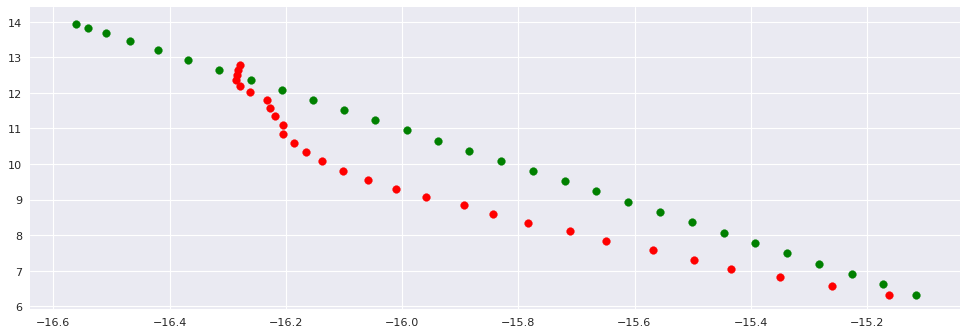

In [20]:
limit = 30
prediction_error = np.zeros((limit, 6))

initial = dataset.iloc[0]
linear_velocities, angular_velocities = predict(10.0, initial, limit)

gen2 = integrateTrajectoryVelocityBody(initialPosition=initial[['x', 'y', 'z']].values,
                                       initialOrientation=initial[['psi', 'theta', 'phi']].values,
                                       linearVelocitiesBody=linear_velocities,
                                       angularVelocities=angular_velocities,
                                       frequency=10.0 * np.ones((limit, )))

figure(num=None, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')

for i in range(1, limit):
    p, o = next(gen2)

    pTrue = dataset.loc[i, ['x', 'y', 'z']]
    oTrue = dataset.loc[i, ['psi', 'theta', 'phi']]
    plt.scatter(pTrue[0], pTrue[1], color='green')

    plt.scatter(p[0], p[1], color='red')
    prediction_error[i-1] = np.concatenate((p-pTrue, np.rad2deg(getAverageAngularVelocity(oTrue, o, 1.0))))


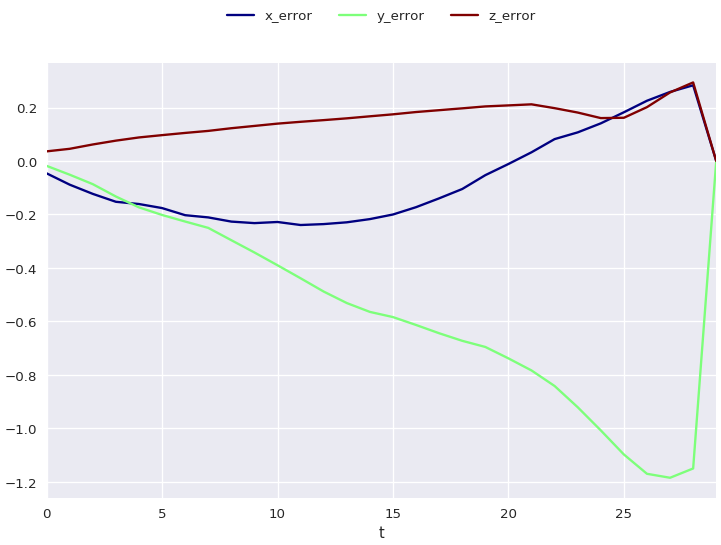

In [21]:
prediction_error_df = pd.DataFrame(prediction_error, columns=['x_error', 'y_error', 'z_error',
                                                              'psi_error', 'theta_error', 'phi_error'])
prediction_error_df['t'] = prediction_error_df.index
display(prediction_error_df)


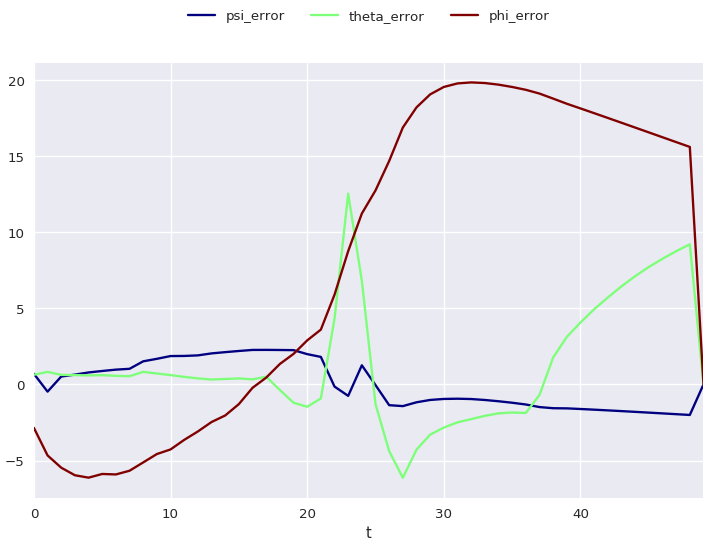

In [19]:
display(prediction_error_df)

In [215]:
from sklearn.externals import joblib
joblib.dump(model, 'C:/Users/talaa/PycharmProjects/rl/src/randomForest.model')

['C:/Users/talaa/PycharmProjects/rl/src/randomForest.model']